<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка данных

In [3]:
import pandas as pd 
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

In [4]:
try:
    data = pd.read_csv('/datasets/taxi.csv')
except:
    data = pd.read_csv('./datasets/taxi.csv') 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
data['datetime'] = data['datetime'].astype('datetime64[ns]')
data = data.set_index('datetime', drop = True)
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [7]:
data.index.is_monotonic_increasing

True

In [8]:
data.index

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 00:10:00',
               '2018-03-01 00:20:00', '2018-03-01 00:30:00',
               '2018-03-01 00:40:00', '2018-03-01 00:50:00',
               '2018-03-01 01:00:00', '2018-03-01 01:10:00',
               '2018-03-01 01:20:00', '2018-03-01 01:30:00',
               ...
               '2018-08-31 22:20:00', '2018-08-31 22:30:00',
               '2018-08-31 22:40:00', '2018-08-31 22:50:00',
               '2018-08-31 23:00:00', '2018-08-31 23:10:00',
               '2018-08-31 23:20:00', '2018-08-31 23:30:00',
               '2018-08-31 23:40:00', '2018-08-31 23:50:00'],
              dtype='datetime64[ns]', name='datetime', length=26496, freq=None)

##### Даты стоят в хронологическом порядке и по возрастанию.

In [9]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

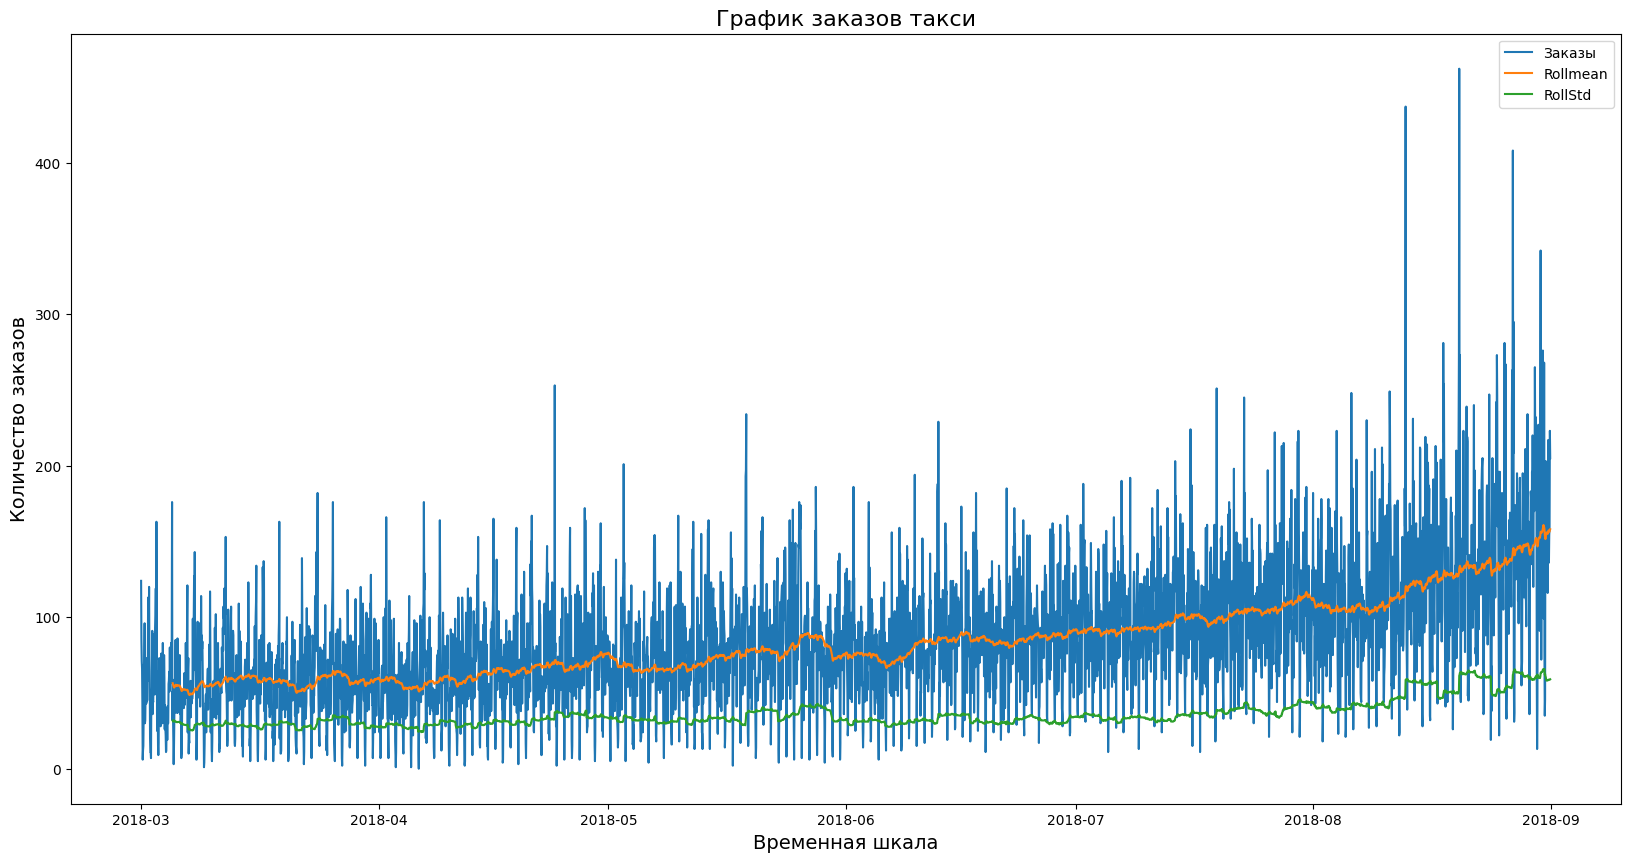

In [10]:
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
ax.set_title('График заказов такси', fontsize=16)
ax.set_xlabel('Временная шкала', fontsize=14)        
ax.set_ylabel('Количество заказов', fontsize=14)
ax.plot(data)
ax.plot(data.rolling(100).mean())
ax.plot(data.rolling(100).std())
ax.legend(['Заказы', 'Rollmean', 'RollStd'])
plt.show()

##### По графику можно заметить, что с марта начинается постепенный рост заказов.

<b> Нулевая гипотеза </b>: ряд не стационарен. <br> 
<b> Альтернативная гипотеза</b>: ряд стационарен. <br> 
    Проверим тестом Дики-Фуллера, пороги значимости 0,05 и 0,01

In [10]:
alpha = 0.05
if adfuller(data)[1] > alpha:
    print ("Ряд нестационарен")
else:
    print('Ряд стационарен')

Ряд стационарен


In [15]:
alpha = 0.01
if adfuller(data)[1] > alpha:
    print ("Ряд нестационарен")
else:
    print('Ряд стационарен')

Ряд нестационарен


Тест проведен на двух уровнях значимости. При 0.01 гипотеза не отвергается. При 0.05 гипотеза отвергается.

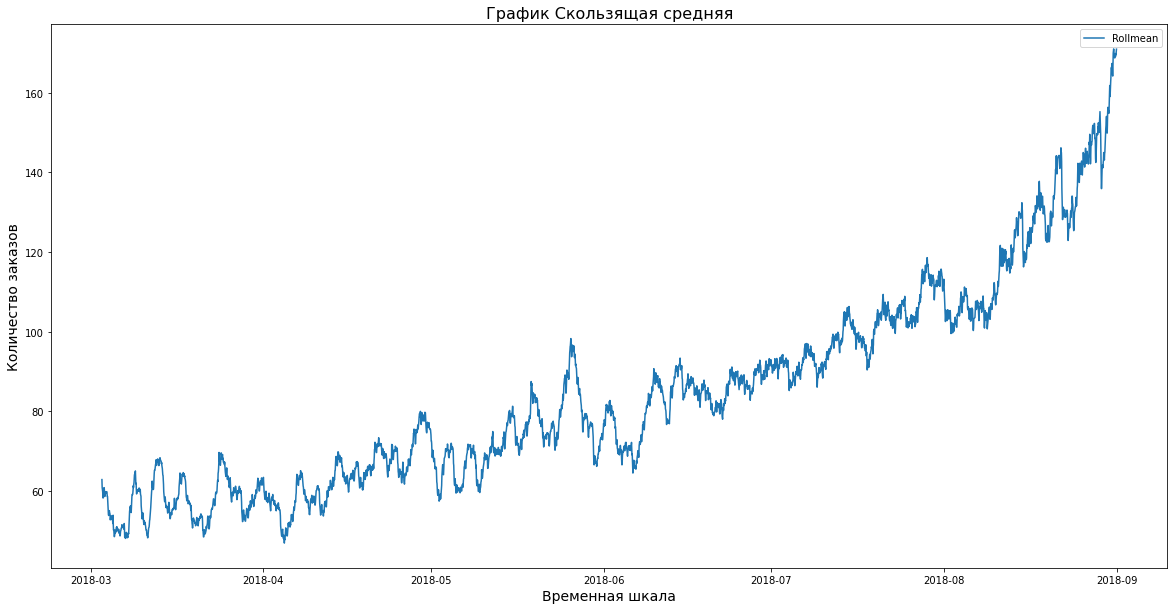

In [27]:
fig, ax = plt.subplots()
ax.set_title('График Скользящая средняя', fontsize=16)
ax.set_xlabel('Временная шкала', fontsize=14)        
ax.set_ylabel('Количество заказов', fontsize=14)
ax.plot(data.rolling(50).mean())
ax.legend(['Rollmean'])
plt.show()

##### Сглаженное среднее постепенно увеличиваться со временем, что указывает на нестационарность ряда.

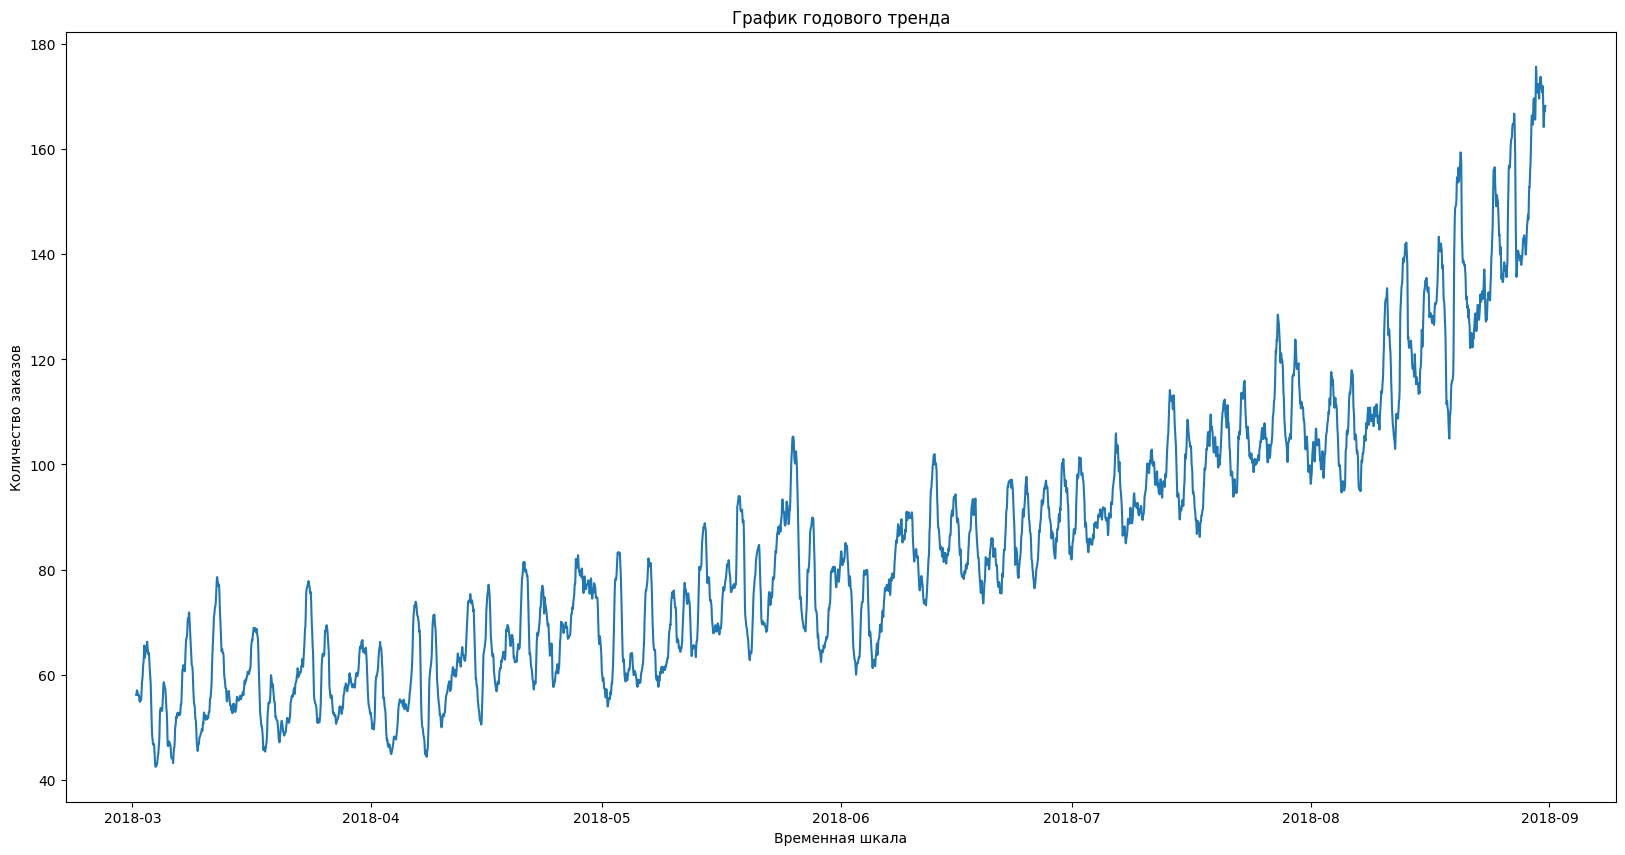

In [12]:
decom = seasonal_decompose(data)
plt.title('График годового тренда')
plt.ylabel('Количество заказов')
plt.xlabel('Временная шкала')
plt.plot(decom.trend)

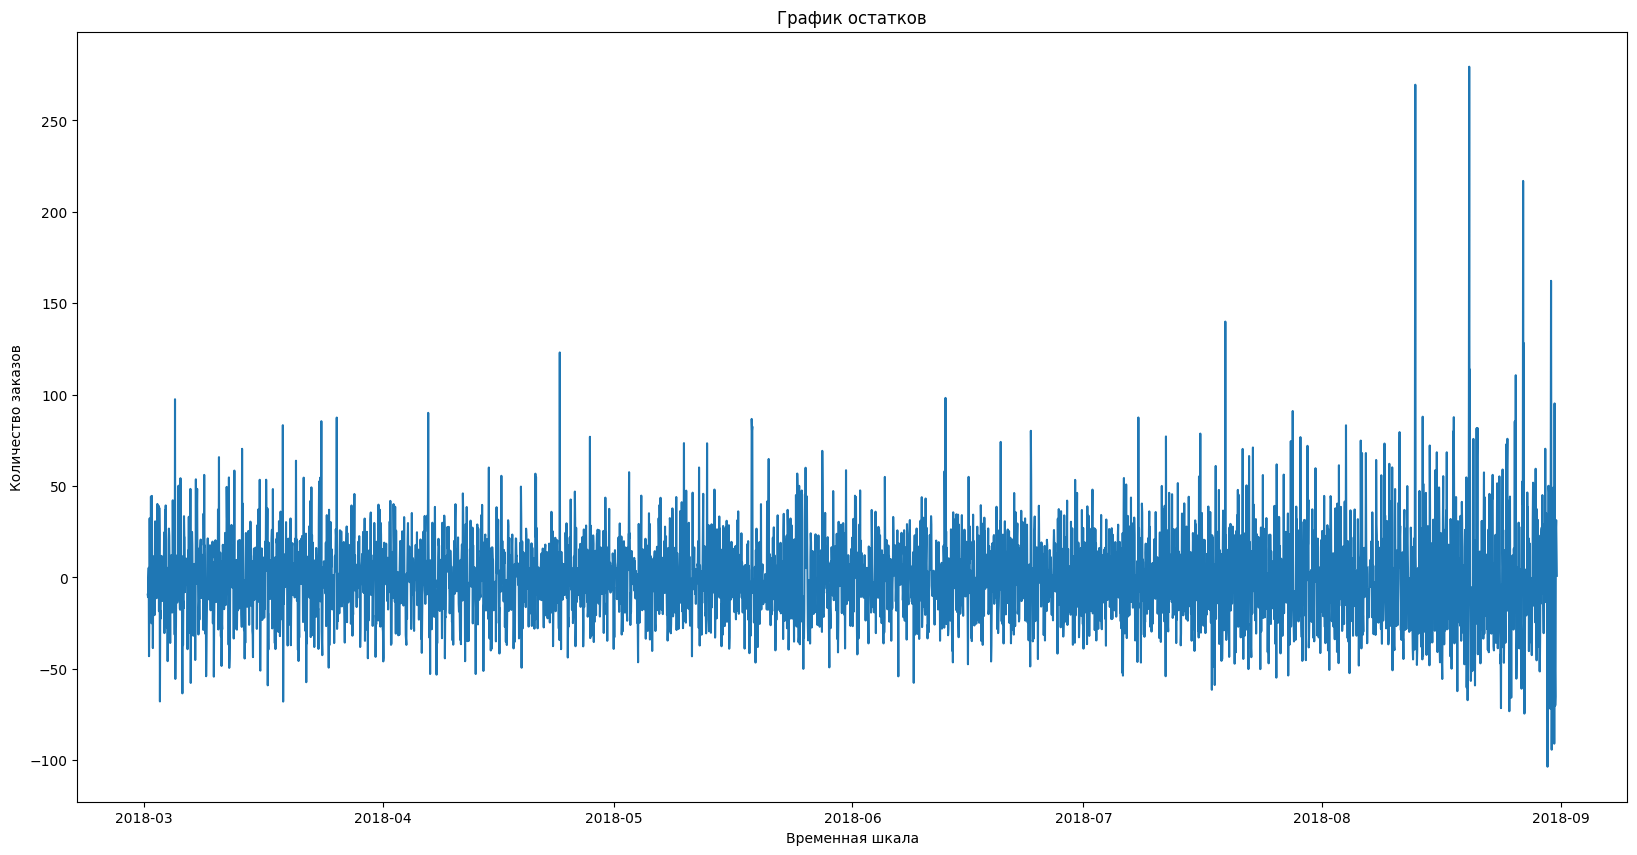

In [13]:
decom = seasonal_decompose(data)
plt.title('График остатков')
plt.ylabel('Количество заказов')
plt.xlabel('Временная шкала')
plt.plot(decom.resid)

##### По графику остатков, можем предположить, что ряд стационарен, так как имеется разброс.

<b> Сделаем вывовод о том, что ряд не стационарен. В дальнейшем перед обучением приведем его к стационарности.

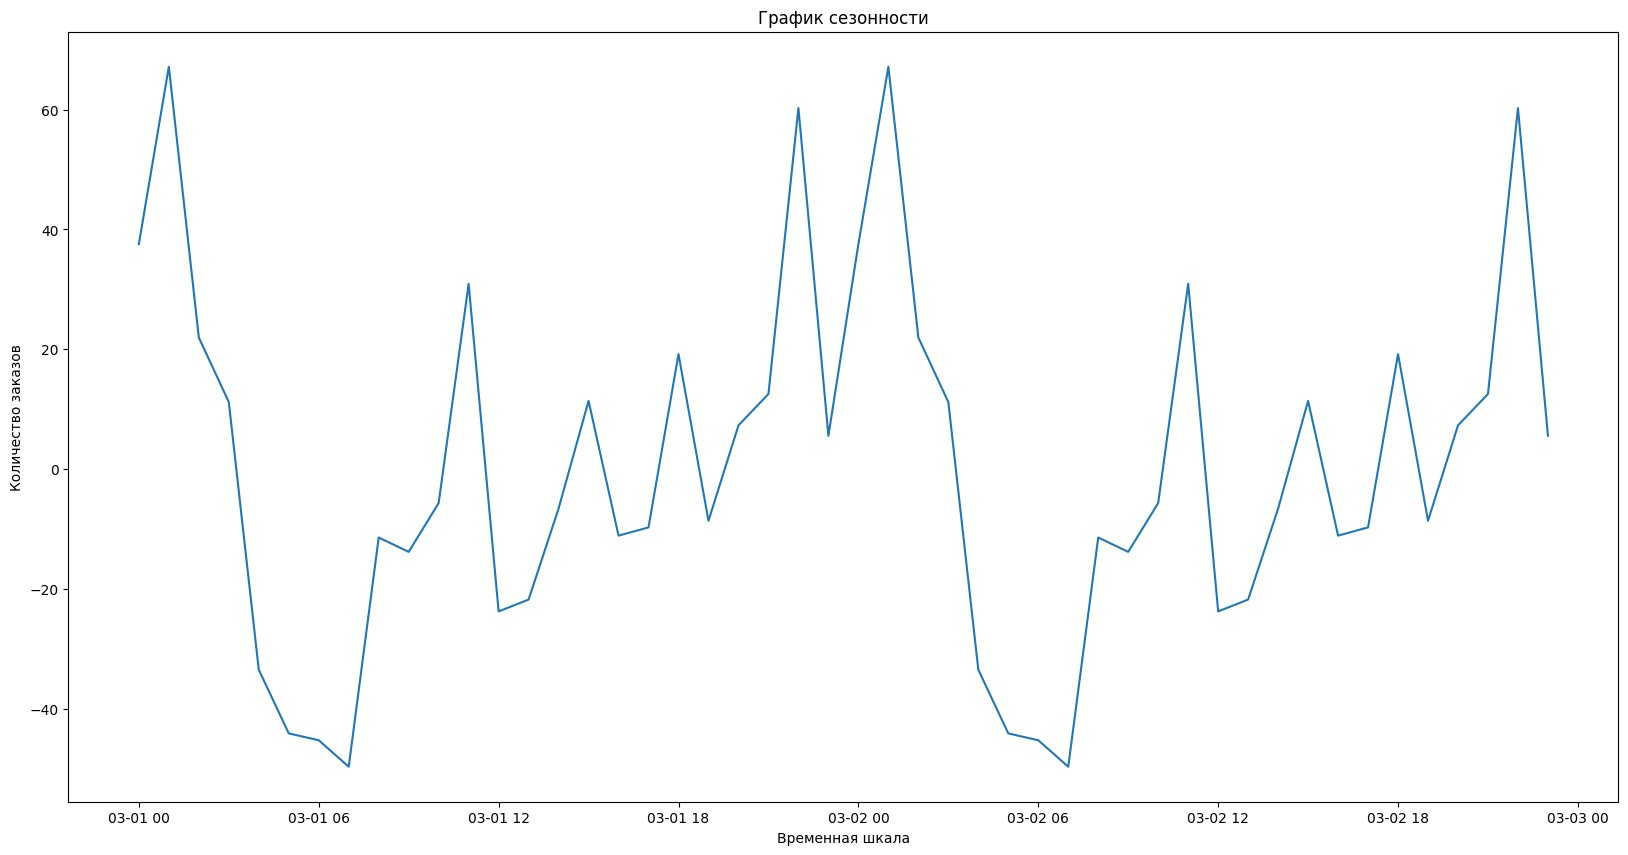

In [14]:
decom = seasonal_decompose(data['2018-03-01':'2018-03-02'])
plt.title('График сезонности')
plt.ylabel('Количество заказов')
plt.xlabel('Временная шкала')
plt.plot(decom.seasonal)

##### При анализе сезооности за 2 дня, можем предполагать, что рост заказов увеличивается пропорционально росту прилетов(вылетов)  авиaсудов в(из) аэропорт(а). 

#### По иследуемым данным можем сделать вывод, что тренд заказов начинается ближе к осени, ряд не стационарен, сезонность заказов такси выпадает на количество вылетов и прилетов авиалайнеров компании. Временной ряд нестационарен.

## Обучение

In [12]:
#stat сделать ряд стационарным
def add_futures (data, lag_col=0, roll=0, stat =False):
    data_restruct = data.copy()
    if stat:
        data_restruct = data_restruct - data_restruct.shift()
    data_restruct['day'] = data_restruct.index.day
    data_restruct['dayofweek'] = data_restruct.index.dayofweek
    if lag_col>0:
        for lag in range(1, lag_col+1):
            data_restruct[f'lag_{lag}'] = data_restruct['num_orders'].shift(lag)
    if roll>0:
        data_restruct['roll'] = data_restruct['num_orders'].shift().rolling(roll).mean()
    return data_restruct
        

In [13]:
data_up = add_futures(data, 40, 9, stat=True).dropna()

In [14]:
data_up

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,roll
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 17:00:00,1.0,2,4,23.0,15.0,-1.0,9.0,-55.0,37.0,9.0,...,35.0,19.0,3.0,6.0,-37.0,-23.0,-5.0,-14.0,-39.0,8.333333
2018-03-02 18:00:00,6.0,2,4,1.0,23.0,15.0,-1.0,9.0,-55.0,37.0,...,-5.0,35.0,19.0,3.0,6.0,-37.0,-23.0,-5.0,-14.0,4.111111
2018-03-02 19:00:00,-40.0,2,4,6.0,1.0,23.0,15.0,-1.0,9.0,-55.0,...,32.0,-5.0,35.0,19.0,3.0,6.0,-37.0,-23.0,-5.0,4.888889
2018-03-02 20:00:00,44.0,2,4,-40.0,6.0,1.0,23.0,15.0,-1.0,9.0,...,-66.0,32.0,-5.0,35.0,19.0,3.0,6.0,-37.0,-23.0,-0.555556
2018-03-02 21:00:00,8.0,2,4,44.0,-40.0,6.0,1.0,23.0,15.0,-1.0,...,2.0,-66.0,32.0,-5.0,35.0,19.0,3.0,6.0,-37.0,0.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,-71.0,31,4,-10.0,20.0,81.0,-17.0,-33.0,30.0,-31.0,...,-71.0,1.0,60.0,127.0,26.0,-43.0,-130.0,-7.0,-39.0,0.444444
2018-08-31 20:00:00,18.0,31,4,-71.0,-10.0,20.0,81.0,-17.0,-33.0,30.0,...,17.0,-71.0,1.0,60.0,127.0,26.0,-43.0,-130.0,-7.0,-6.111111
2018-08-31 21:00:00,5.0,31,4,18.0,-71.0,-10.0,20.0,81.0,-17.0,-33.0,...,-19.0,17.0,-71.0,1.0,60.0,127.0,26.0,-43.0,-130.0,-1.444444


In [15]:
data_up, data_test = train_test_split(data_up, shuffle=False, test_size=0.1)

In [16]:
data_test.shape[0]/data_up.shape[0] * 100

11.125222250444502

In [17]:
target = data_up['num_orders']
futures = data_up.drop('num_orders', axis = 1)

##### Выборки подготовлены, начинаем обучение моделей.

<b> Линейная регрессия

In [18]:
scoring = make_scorer(mean_squared_error, greater_is_better=False)

In [82]:
tss = TimeSeriesSplit(n_splits = 5)

In [20]:
model = LinearRegression()
model.fit(futures, target)
(cross_val_score(model, X=futures, y=target, scoring=scoring, cv=tss).mean()*-1)**0.5

27.081312844954663

<b> CatBoost

In [83]:
grid = {'learning_rate': [0.3, 0.5],
        'depth': [4,6],
        'iterations': [500]}
model_cat = GridSearchCV(estimator = CatBoostRegressor(random_state=300591), 
                    param_grid=grid,
                    n_jobs=-1,
                    cv=tss,
                    scoring=scoring)
model_cat.fit(futures, target)

0:	learn: 33.8192033	total: 16.4ms	remaining: 8.17s
1:	learn: 32.2780450	total: 31.7ms	remaining: 7.9s
2:	learn: 31.3203919	total: 45.1ms	remaining: 7.47s
3:	learn: 30.4464720	total: 58.5ms	remaining: 7.25s
4:	learn: 29.7679796	total: 74.7ms	remaining: 7.39s
5:	learn: 29.0949403	total: 91.1ms	remaining: 7.5s
6:	learn: 28.7243420	total: 108ms	remaining: 7.59s
7:	learn: 28.3342252	total: 125ms	remaining: 7.67s
8:	learn: 27.8470038	total: 142ms	remaining: 7.76s
9:	learn: 27.3208487	total: 160ms	remaining: 7.85s
10:	learn: 26.9817170	total: 180ms	remaining: 7.98s
11:	learn: 26.7048390	total: 201ms	remaining: 8.16s
12:	learn: 26.4531357	total: 221ms	remaining: 8.29s
13:	learn: 26.1556688	total: 264ms	remaining: 9.16s
14:	learn: 25.8466015	total: 319ms	remaining: 10.3s
15:	learn: 25.7233684	total: 336ms	remaining: 10.2s
16:	learn: 25.4624823	total: 355ms	remaining: 10.1s
17:	learn: 25.1744301	total: 372ms	remaining: 9.97s
18:	learn: 24.9870518	total: 391ms	remaining: 9.89s
19:	learn: 24.8493

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x0000023BF6EBA6B0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6], 'iterations': [500],
                         'learning_rate': [0.3, 0.5]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [84]:
(model_cat.best_score_*-1)**0.5

28.651071262387966

<b> LGBM

In [85]:
param_grid = {
'learning_rate': [0.1, 0.01, 0.5],
'n_estimators': [10, 25, 50, 100, 150],
'max_depth': [2, 6,],
'num_leaves': [20,50,100]
}
estim = lgbm.LGBMRegressor(objective='regression', random_state = 300591 )
model_lbgm = GridSearchCV(estimator=estim, 
                    param_grid=param_grid,
                    n_jobs=-1,
                    cv=tss,
                    scoring='neg_mean_squared_error')

model_lbgm.fit(futures, target)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(objective='regression',
                                     random_state=300591),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.5], 'max_depth': [2, 6],
                         'n_estimators': [10, 25, 50, 100, 150],
                         'num_leaves': [20, 50, 100]},
             scoring='neg_mean_squared_error')

In [86]:
(model_lbgm.best_score_*-1)**0.5

28.421800165490094

#### Лучший показатель метрики RMSE имеет линейная регрессия.

## Тестирование

In [29]:
target_test = data_test['num_orders']
futures_test = data_test.drop('num_orders', axis=1)

In [30]:
p_li = model.predict(futures_test)

In [31]:
mean_squared_error(target_test, p_li) **0.5

44.43870243588137

In [32]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(futures,target)
pred = dummy.predict(futures_test)
mean_squared_error(target_test, pred)**0.5

58.996193162942575

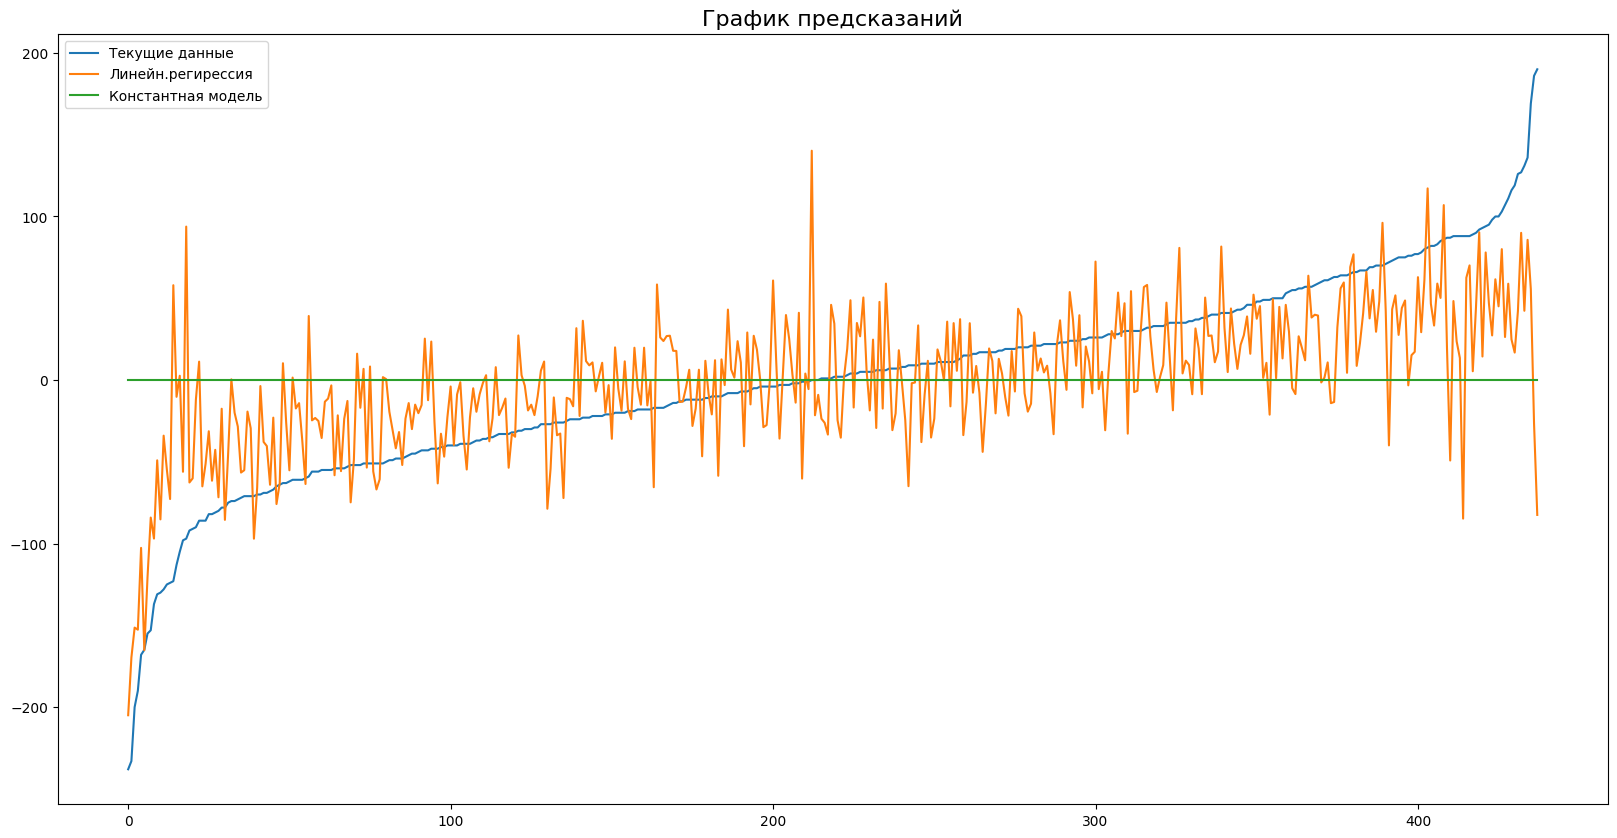

In [291]:
graph = target_test.reset_index().drop('datetime', axis=1)
graph['pred'] = pd.Series(p_li)
graph['const'] = pd.Series(pred) 
graph = graph.sort_values('num_orders')

fig, ax = plt.subplots()
ax.set_title('График предсказаний', fontsize=16)
plt.plot(graph['num_orders'].values)
plt.plot(graph['pred'].values)
plt.plot(graph['const'].values)
ax.legend(['Текущие данные', 'Линейн.регирессия', 'Константная модель'])
plt.show()


### Вывод:

Модель линейной регрессии имеет лучший результат метрики. Констанстная модель отлична, что говорит об акутальности нашей модели. Порог значимости метрики не превышен. Задача выполнена.